## Two models combined with reduced features

This notebook is used to combine two models with two different tasks. The first one is the classification of wake vs sleep and will be trained only on EMGv features, the second one is the classification of the sleep stages and will be trained only on EEGv features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
import os
from sklearn.preprocessing import StandardScaler, Normalizer 
from sklearn.ensemble import RandomForestClassifier
# from imblearn.ensemble import BalancedRandomForestClassifier

import sys
sys.path.append('../Library')

import breedManip as breedManip
import dataProcessing as dataProcessing
import breeds as breeds
import splitData as splitData

import importlib
importlib.reload(splitData)


2023-07-25 14:01:48.360252: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-25 14:01:48.442657: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-25 14:01:49.668245: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


<module 'splitData' from '/mnt/remote/workspaces/magali.egger/TBproject/Travail_Bachelor/ClassificationSimple/../Library/splitData.py'>

Data preparation

In [2]:
with open('/home/magali.egger/shared-projects/mice_UNIL/Data/df_simplify_day3.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
mice_test = ['BL601', 'BL602', 'BL606', 'BL609', '1D203', '2D203', '1D204', '1D206', '00505', '04501', '04502', '04504', '04505', '04506', '04508', '04801', '04802', '04803', '04804', '04805', '04806', '05001', '05002', '05003', '05004', '05005', '05006', '07901', '07902', '08405', '08502', '08503', '08901', '08902', '09001', '09003', '09004', '09005', '09006', '09007', '10101', '10102']
df = df[~df['mouse'].isin(mice_test)]

In [4]:
df_train, df_test = splitData.split_data_breeds(df, 30)

In [5]:
df_train = df_train.drop(columns=['mouse'])
df_train = df_train.drop(columns=['breed'])
df_test = df_test.drop(columns=['mouse'])
df_test = df_test.drop(columns=['breed'])

Specific preparation for wake versus sleep classification

In [6]:
# df for the model wake/sleep needs labels 'n' and 'r' to be changed in 's'
df_train_ws= df_train.copy()
df_train_ws['rawState'] = df_train_ws['rawState'].replace(['n', 'r'], 's')
df_test_ws= df_test.copy()
df_test_ws['rawState'] = df_test_ws['rawState'].replace(['n', 'r'], 's')

In [47]:
# keeps only the EMG features
emg_columns = ['rawState', 'state']
# add the columns that contain the EEG
emg_columns.extend([col for col in df_train.columns if 'EMG' in col])
print(emg_columns)

df_train_ws = df_train_ws[emg_columns]
df_test_ws = df_test_ws[emg_columns]

['rawState', 'state', 'EMGv', 'EMGv_mean2', 'EMGv_median2', 'EMGv_var2', 'EMGv_min2', 'EMGv_max2', 'EMGv_mean5', 'EMGv_median5', 'EMGv_var5', 'EMGv_min5', 'EMGv_max5', 'EMGv_mean10', 'EMGv_median10', 'EMGv_var10', 'EMGv_min10', 'EMGv_max10', 'EMGv_mean20', 'EMGv_median20', 'EMGv_var20', 'EMGv_min20', 'EMGv_max20', 'EMGv_mean50', 'EMGv_median50', 'EMGv_var50', 'EMGv_min50', 'EMGv_max50', 'EMGv_mean100', 'EMGv_median100', 'EMGv_var100', 'EMGv_min100', 'EMGv_max100', 'EMGv_log', 'EMGv^2', 'EMGv^3']


In [12]:
x_train_ws, y_train_ws_raw = splitData.split_labels(df_train_ws)
y_train_ws, le_ws = splitData.encode_labels(y_train_ws_raw, cat_matrix=True)

scaler_ws = StandardScaler().fit(x_train_ws)
x_train_ws = scaler_ws.transform(x_train_ws)

In [13]:
x_test_ws, y_test_ws_raw = splitData.split_labels(df_test_ws)

y_test_ws = le_ws.transform(y_test_ws_raw)
y_test_ws = tf.keras.utils.to_categorical(y_test_ws)

x_test_ws = scaler_ws.transform(x_test_ws)

Specific preparation for sleep stages classification

In [14]:
# df for the model rem/nrem needs to remove the 'w' label
df_train_sleep = df_train.copy()
df_train_sleep = df_train_sleep[df_train_sleep['rawState'] != 'w']
df_test_sleep = df_test.copy()
df_test_sleep = df_test_sleep[df_test_sleep['rawState'] != 'w']

In [46]:
eeg_columns = ['rawState', 'state', 'EEGv', 'spectral_flatness', 'spectral_centroid', 'spectral_entropy','spectral_rolloff_0.1', 'spectral_rolloff_0.2', 'spectral_rolloff_0.3', 'spectral_rolloff_0.4', 'spectral_rolloff_0.5', 'spectral_rolloff_0.6', 'spectral_rolloff_0.7', 'spectral_rolloff_0.8', 'spectral_rolloff_0.9' ]
# add the columns that contain the EMG 
eeg_columns.extend([col for col in df_train.columns if 'EEG' in col])
print(eeg_columns)

df_train_sleep = df_train_sleep[eeg_columns]
df_test_sleep = df_test_sleep[eeg_columns]

['rawState', 'state', 'EEGv', 'spectral_flatness', 'spectral_centroid', 'spectral_entropy', 'spectral_rolloff_0.1', 'spectral_rolloff_0.2', 'spectral_rolloff_0.3', 'spectral_rolloff_0.4', 'spectral_rolloff_0.5', 'spectral_rolloff_0.6', 'spectral_rolloff_0.7', 'spectral_rolloff_0.8', 'spectral_rolloff_0.9', 'EEGv', 'EEGv_mean2', 'EEGv_median2', 'EEGv_var2', 'EEGv_min2', 'EEGv_max2', 'EEGv_mean5', 'EEGv_median5', 'EEGv_var5', 'EEGv_min5', 'EEGv_max5', 'EEGv_mean10', 'EEGv_median10', 'EEGv_var10', 'EEGv_min10', 'EEGv_max10', 'EEGv_mean20', 'EEGv_median20', 'EEGv_var20', 'EEGv_min20', 'EEGv_max20', 'EEGv_mean50', 'EEGv_median50', 'EEGv_var50', 'EEGv_min50', 'EEGv_max50', 'EEGv_mean100', 'EEGv_median100', 'EEGv_var100', 'EEGv_min100', 'EEGv_max100', 'EEGv_log', 'EEGv^2', 'EEGv^3']


In [16]:
x_train_sleep, y_train_sleep_raw = splitData.split_labels(df_train_sleep)
y_train_sleep, le_sleep = splitData.encode_labels(y_train_sleep_raw, cat_matrix=True)

scaler_sleep = StandardScaler().fit(x_train_sleep)
x_train_sleep = scaler_sleep.transform(x_train_sleep)

In [17]:
x_test_sleep, y_test_sleep_raw = splitData.split_labels(df_test_sleep)

y_test_sleep = le_sleep.transform(y_test_sleep_raw)
y_test_sleep = tf.keras.utils.to_categorical(y_test_sleep)

x_test_sleep = scaler_sleep.transform(x_test_sleep)

Training of sleep versus wake model

In [18]:
rfc_ws = RandomForestClassifier(random_state=23, n_jobs=-1, class_weight='balanced')
rfc_ws.fit(x_train_ws, y_train_ws)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=23)

In [19]:
y_pred_ws = rfc_ws.predict(x_test_ws)

[[266195  30630]
 [ 26342 380525]]
              precision    recall  f1-score   support

           s       0.91      0.90      0.90    296825
           w       0.93      0.94      0.93    406867

    accuracy                           0.92    703692
   macro avg       0.92      0.92      0.92    703692
weighted avg       0.92      0.92      0.92    703692



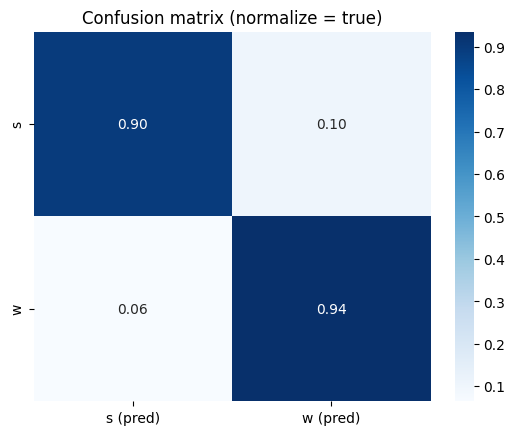

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
pred = np.argmax(y_pred_ws, axis=1)
test = np.argmax(y_test_ws, axis=1)

# plot the confusion matrix between predictions of the model and real values

cm = np.array(confusion_matrix(test, pred))
print(cm)

cm = np.array(confusion_matrix(test, pred, normalize='true')) # normalize = 'true' or 'pred'
confusion = pd.DataFrame(cm, index=le_ws.classes_, columns=le_ws.classes_ + ' (pred)')

print(classification_report(test, pred, target_names=le_ws.classes_, zero_division=0))

sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
plt.title(f'Confusion matrix (normalize = true)')
plt.show()

Training of sleep stages model

In [21]:
rfc_sleep = RandomForestClassifier(random_state=23, n_jobs=-1, class_weight='balanced')
rfc_sleep.fit(x_train_sleep, y_train_sleep)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=23)

In [22]:
y_pred_sleep = rfc_sleep.predict(x_test_sleep)

[[256716   2185]
 [  7468  30456]]
              precision    recall  f1-score   support

           n       0.97      0.99      0.98    258901
           r       0.93      0.80      0.86     37924

    accuracy                           0.97    296825
   macro avg       0.95      0.90      0.92    296825
weighted avg       0.97      0.97      0.97    296825



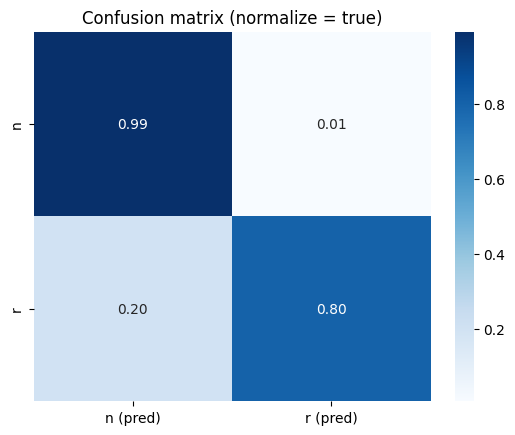

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
pred = np.argmax(y_pred_sleep, axis=1)
test = np.argmax(y_test_sleep, axis=1)

# plot the confusion matrix between predictions of the model and real values

cm = np.array(confusion_matrix(test, pred))
print(cm)

cm = np.array(confusion_matrix(test, pred, normalize='true')) # normalize = 'true' or 'pred'
confusion = pd.DataFrame(cm, index=le_sleep.classes_, columns=le_sleep.classes_ + ' (pred)')

print(classification_report(test, pred, target_names=le_sleep.classes_, zero_division=0))

sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
plt.title(f'Confusion matrix (normalize = true)')
plt.show()

Evaluation of the two models combined

In [48]:
with open('/home/magali.egger/shared-projects/mice_UNIL/Data/df_simplify_labels.pkl', 'rb') as f:
    df_simplify_labels = pickle.load(f)

In [49]:
# remove wierd labels
wierd_labels = ['a','8', 's', 'j', '1', '2', '3']
df_simplify_labels = df_simplify_labels[~df_simplify_labels['label'].isin(wierd_labels)]

In [50]:
df_simplify_labels = df_simplify_labels.drop(columns=['mouse'])
df_simplify_labels = df_simplify_labels.drop(columns=['breed'])

In [62]:
# emg_columns_train is the emg_columns but without the rawState and state columns

emg_columns_train = ([col for col in df_simplify_labels.columns if 'EMG' in col])

eeg_columns_train =['EEGv', 'spectral_flatness', 'spectral_centroid', 'spectral_entropy','spectral_rolloff_0.1', 'spectral_rolloff_0.2', 'spectral_rolloff_0.3', 'spectral_rolloff_0.4', 'spectral_rolloff_0.5', 'spectral_rolloff_0.6', 'spectral_rolloff_0.7', 'spectral_rolloff_0.8', 'spectral_rolloff_0.9' ]
# add the columns that contain the EMG 
eeg_columns_train.extend([col for col in df_train.columns if 'EEG' in col])

In [64]:
x_test, y_test_raw = splitData.split_labels_annotated(df_simplify_labels)

x_test_ws = x_test[emg_columns_train]
x_test_sleep = x_test[eeg_columns_train]

In [65]:


x_test_ws = scaler_ws.transform(x_test_ws)
x_test_sleep = scaler_sleep.transform(x_test_sleep)

In [66]:
def convert(states):
    res = []
    for state in states:
        if state == 'n' or state == '5' or state=='2':
            res.append(0)
        elif state == 'r' or state=='6' or state=='3':
            res.append(1)
        elif state == 'w' or state=='4' or state=='1' or state=='9':
            res.append(2)
    return res

In [67]:
y_test = convert(y_test_raw)

In [68]:
y_pred_ws = rfc_ws.predict(x_test_ws)
y_pred_sleep = rfc_sleep.predict(x_test_sleep)

In [69]:
pred_ws = np.argmax(y_pred_ws, axis=1)
pred_sleep = np.argmax(y_pred_sleep, axis=1)

In [70]:
result = []

for i in range(len(pred_ws)):
    if pred_ws[i] == 0:
        if pred_sleep[i] == 0:
            result.append(0)
        else:
            result.append(1)
    else:
        result.append(2)

[[1178392   11768  152389]
 [  38438  122494   13215]
 [ 158274   30976 1343273]]
              precision    recall  f1-score   support

           n       0.86      0.88      0.87   1342549
           r       0.74      0.70      0.72    174147
           w       0.89      0.88      0.88   1532523

    accuracy                           0.87   3049219
   macro avg       0.83      0.82      0.82   3049219
weighted avg       0.87      0.87      0.87   3049219



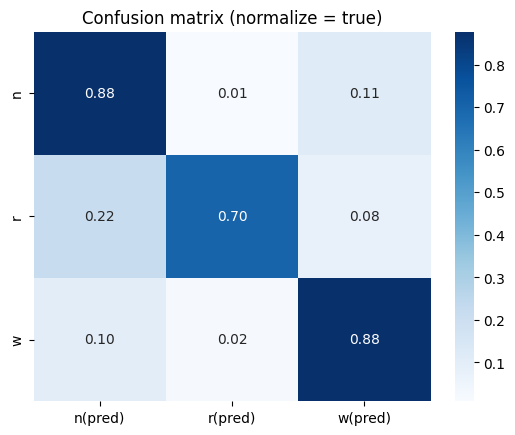

In [71]:
from sklearn.metrics import classification_report, confusion_matrix
pred = result
test = y_test

# plot the confusion matrix between predictions of the model and real values

cm = np.array(confusion_matrix(test, pred))
print(cm)

cm = np.array(confusion_matrix(test, pred, normalize='true')) # normalize = 'true' or 'pred'
confusion = pd.DataFrame(cm, index=['n', 'r', 'w'], columns=['n(pred)', 'r(pred)', 'w(pred)'])

print(classification_report(test, pred, target_names=['n', 'r', 'w'], zero_division=0))

sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
plt.title(f'Confusion matrix (normalize = true)')
plt.show()

In [73]:
print(eeg_columns)

['rawState', 'state', 'EEGv', 'spectral_flatness', 'spectral_centroid', 'spectral_entropy', 'spectral_rolloff_0.1', 'spectral_rolloff_0.2', 'spectral_rolloff_0.3', 'spectral_rolloff_0.4', 'spectral_rolloff_0.5', 'spectral_rolloff_0.6', 'spectral_rolloff_0.7', 'spectral_rolloff_0.8', 'spectral_rolloff_0.9', 'EEGv', 'EEGv_mean2', 'EEGv_median2', 'EEGv_var2', 'EEGv_min2', 'EEGv_max2', 'EEGv_mean5', 'EEGv_median5', 'EEGv_var5', 'EEGv_min5', 'EEGv_max5', 'EEGv_mean10', 'EEGv_median10', 'EEGv_var10', 'EEGv_min10', 'EEGv_max10', 'EEGv_mean20', 'EEGv_median20', 'EEGv_var20', 'EEGv_min20', 'EEGv_max20', 'EEGv_mean50', 'EEGv_median50', 'EEGv_var50', 'EEGv_min50', 'EEGv_max50', 'EEGv_mean100', 'EEGv_median100', 'EEGv_var100', 'EEGv_min100', 'EEGv_max100', 'EEGv_log', 'EEGv^2', 'EEGv^3']


In [74]:
print(emg_columns)

['rawState', 'state', 'EMGv', 'EMGv_mean2', 'EMGv_median2', 'EMGv_var2', 'EMGv_min2', 'EMGv_max2', 'EMGv_mean5', 'EMGv_median5', 'EMGv_var5', 'EMGv_min5', 'EMGv_max5', 'EMGv_mean10', 'EMGv_median10', 'EMGv_var10', 'EMGv_min10', 'EMGv_max10', 'EMGv_mean20', 'EMGv_median20', 'EMGv_var20', 'EMGv_min20', 'EMGv_max20', 'EMGv_mean50', 'EMGv_median50', 'EMGv_var50', 'EMGv_min50', 'EMGv_max50', 'EMGv_mean100', 'EMGv_median100', 'EMGv_var100', 'EMGv_min100', 'EMGv_max100', 'EMGv_log', 'EMGv^2', 'EMGv^3']
